# 📺 Denoise a map with custom inputs

This notebook takes you step by step through the same procedure as used by `meteor.diffmap`, but in a notebook. There is one difference: we assume you've got some pre-computed phases that you want to employ, rather than computing phases from a structural model (CIF/PDB).

In [1]:
# ruff: noqa: T201

import numpy as np
import reciprocalspaceship as rs
from matplotlib import pyplot as plt

from meteor.diffmaps import compute_difference_map, max_negentropy_kweighted_difference_map
from meteor.rsmap import Map
from meteor.tv import tv_denoise_difference_map
from meteor.validate import map_negentropy

### 1. Load the data of interest

We'll use `scaled-test-data.mtz`, an test/example MTZ provided in this repo. The data come from a real experiment, Fadini _et al._ (**2023**) _J Am Chem Soc_ 145: 15796-15808 (https://doi.org/10.1021/jacs.3c02313), where the authors imaged the cis-trans isomerization of rsEGFP2. The MTZ contains a lot of columns -- we'll ignore most of them and focus on.

- the amplitudes and phases for a dark reference dataset
- amplitudes for a light-activated dataset

In [2]:
# path is relative to where this notebook usually is in the `meteor` repo
mtz_path = "../meteor/test/data/scaled-test-data.mtz"
mtz_dataset = rs.read_mtz(mtz_path)

print(mtz_dataset.columns)

Index(['F_on', 'SIGF_on', 'F_off', 'SIGF_off', 'FC_nochrom', 'PHIC_nochrom',
       'F_on_scaled', 'SIGF_on_scaled', 'F_off_scaled', 'SIGF_off_scaled',
       'F_k', 'SIGF_k', 'PHI_k', 'F_TV', 'PHI_TV', 'SIGF_TV', 'F_itTV',
       'SIGF_itTV', 'PHI_itTV'],
      dtype='object')


We'll use the same phase column for both the `native` and `derivative` datasets we're comparing, making the maps we compute isomorphous difference maps. Note that's not a requirement, though!

In this case, the phases were computed _omitting_ the chromophore where isomerization was expected, so the results should not be biased by the starting model at all. This is a nice application of a custom phase calculation. But: the same effect could be achieved by passing a model without the chromophore to `meteor.diffmap` 😊.

In [3]:
native_map = Map(
    mtz_dataset,
    amplitude_column="F_off",
    phase_column="PHIC_nochrom",
    uncertainty_column="SIGF_off",
)

derivative_map = Map(
    mtz_dataset,
    amplitude_column="F_on",
    phase_column="PHIC_nochrom",
    uncertainty_column="SIGF_on",
)

In [4]:
# for a reference, let's compute a "vanilla" difference map to benchmark the initial negentropy
vanilla_isomorphous_diffmap = compute_difference_map(derivative_map, native_map)
initial_negentropy = map_negentropy(vanilla_isomorphous_diffmap)

print(f"initial negentropy: {initial_negentropy:.5f}")

initial negentropy: 0.00114


### 2. Compute a _k_-weighted difference map

Now, we'll compute a _k_-weighted difference map, varying the _k_-parameter to maximize the difference map negentropy.

In [5]:
k_weighted_diffmap, kparameter_metadata = max_negentropy_kweighted_difference_map(
    derivative_map, native_map
)
kewighted_negentropy = map_negentropy(k_weighted_diffmap)

print(f"optimal k-parameter: {kparameter_metadata.optimal_parameter_value}")
print(f"negentropy: {kewighted_negentropy:.5f}")

optimal k-parameter: 0.01
negentropy: 0.00127


### 3. TV denoise the map

Finally, the main event, the entreé! Let's improve our _k_-weighted map by TV-denoising it.

In [6]:
tv_denoised_map, metadata = tv_denoise_difference_map(k_weighted_diffmap, full_output=True)

We can inspect the run `metadata` to observe the optimization in progress -- the Golden section method should nicely sample the region around the maximum more densely.

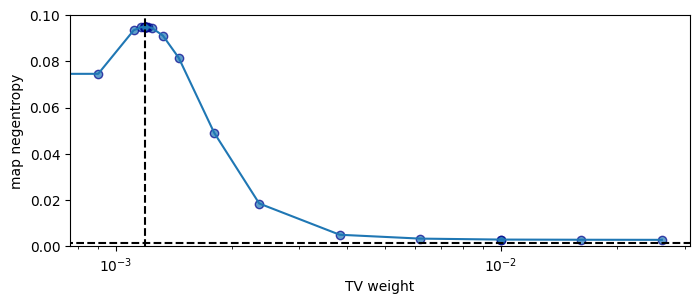

In [7]:
plt.figure(figsize=(8, 3))

plt.xlabel("TV weight")
plt.ylabel("map negentropy")
plt.xscale("log")

# points are not sampled in order of increasing TV weight, so we have to order them
tv_weights_scanned = [pt.parameter_value for pt in metadata.parameter_scan_results]
negentropy_at_weights = [pt.objective_value for pt in metadata.parameter_scan_results]
sort_order = np.argsort(tv_weights_scanned)

plt.plot(
    np.array(tv_weights_scanned)[sort_order],
    np.array(negentropy_at_weights)[sort_order],
)

plt.scatter(
    tv_weights_scanned,
    negentropy_at_weights,
    edgecolors="darkblue",
    linewidths=1,
    alpha=0.7,
)

plt.hlines(metadata.initial_negentropy, 0, 0.05, color="black", linestyle="dashed")
plt.vlines(metadata.optimal_parameter_value, -0.01, 0.10, color="black", linestyle="dashed")
plt.ylim([0, 0.10])

plt.show()

### 4. Write out the results

Awesome! Now we have a fancy new diffmap, which we probably want to save so we can do something with it. Like fire up Coot and check it out. If you are curious, the PDB ID corresponding to this dataset is `8a6g`, and you can find a copy of the structure as a PDB file in this repository:

> `../test/data/8a6g.pdb`

In [19]:
# tv_denoised_map.write_mtz("my_denoised_diffmap.mtz")

In [14]:
from plotting3d import *

In [15]:
def slice_3d(mtzdata, gif_name="", extent=None, startval=10, is_diff=False):
    xlen, ylen, zlen = mtzdata.shape
    xline = np.linspace(0, 1, xlen)
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot()
    ax.set_title(xline[0])
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    extent = [1, 0, 0, 1] if extent is None else extent
    if is_diff:
        vmax = np.max(np.abs(mtzdata))
        imkwargs = {"cmap": "bwr",  "vmax":vmax, "vmin":-vmax}
    else:
        imkwargs ={}
    im = plt.imshow(mtzdata[startval], extent=extent, **imkwargs)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        
    @widgets.interact(f0=(0, len(xline) - 1, 1))
    def update(f0=0):
        im.set_data(mtzdata[f0])
        ax.set_title(f"z={xline[f0]:.3f}")

    if gif_name != "":
        anim = animation.FuncAnimation(fig, update, frames=len(xline), interval=500)
        anim.save(gif_name)
        plt.show()
        return anim

In [16]:
tv_denoised=rs.DataSet(tv_denoised_map)
tv_denoised["sf"] = tv_denoised.to_structurefactor("F","PHI")
tv_denoised_grid = tv_denoised.to_reciprocal_grid("sf")
tv_denoised_real = np.fft.ifftn(tv_denoised_grid)


/var/folders/pr/w1s1g8813qn100g39nl2z99m0000gp/T/ipykernel_13726/1605096000.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


interactive(children=(IntSlider(value=0, description='f0', max=119), Output()), _dom_classes=('widget-interact…

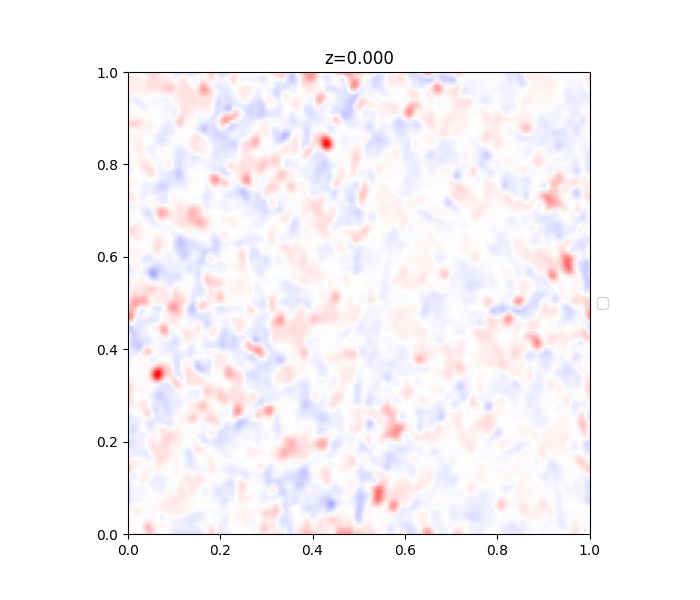

In [17]:
%matplotlib widget
imkwargs={"cmap":"bwr"}
slice_3d(tv_denoised_real.real, is_diff=True)

interactive(children=(IntSlider(value=0, description='f0', max=119), Output()), _dom_classes=('widget-interact…

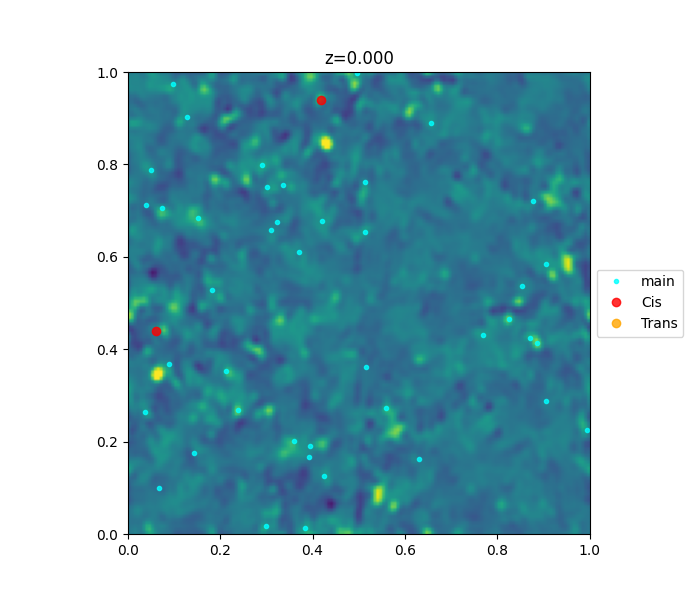

In [18]:
dataloc = "../synthetic_cistrans/"
pdbname_light = dataloc+"100ps.pdb"
struc_light = gemmi.read_structure(pdbname_light)
pdbname_dark = dataloc + "trans.pdb"
struc_dark = gemmi.read_structure(pdbname_dark)

pos_list = np.array([(rca.atom.pos).tolist()   for rca in struc_light[0].all()])
for idx in range(3):
    diff = np.max(pos_list[:,idx])-np.min(pos_list[:,idx])
frac_list, occ_mask=get_pos_from_pdb(struc_light, search_occ=0.27)
# np.flip(obj1-obj0,(0,1,2))
tv_real = tv_denoised_real.real
tv_real = np.flip(tv_real,(0,1,2))
mtz_comp(frac_list,occ_mask, tv_real[::-1] ,extent=[0,1,1,0]) 
